# OHCL - Analytics

### Import Library

In [102]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [103]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [104]:
data = dataset.copy()

In [105]:
data["ma_line"] = data["Close"].rolling(20).mean()
data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
data['total_above_ma'] = data['above_ma'].rolling(150).sum()
data['total_below_ma'] = data['below_ma'].rolling(150).sum()
data['trend_diff'] = data['total_above_ma'] - data['total_below_ma']
data['ibs'] = data.apply(
    lambda r: 0 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)

In [106]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
data['Close_9h'] = data['Close']
data['Close_14h'] = data['Close']
data["RSI"] = ta.rsi(data["Close"], length=14)
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h,
        'RSI': bar9h,
        'trend_diff': bar9h,
        'ibs': bar9h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [107]:
day_data = day_data[day_data.High != day_data.Low]
def get_percent(r):
    return (r['Close_9h'] - r['Low']) / (r['High'] - r['Low'])
day_data['percent'] = day_data.apply(lambda r: get_percent(r), axis=1)

In [108]:
day_data

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,percent
Date,,,,,,,,,,
2018-08-13,943.5,954.2,954.6,942.3,943.1,949.5,NaN,NaN,0.285714,0.065041
2018-08-14,955.5,959.3,961.8,952.1,954.9,960.8,79.515026,NaN,0.250000,0.288660
2018-08-15,958.0,946.6,962.3,946.6,958.7,957.7,54.984480,NaN,0.875000,0.770701
2018-08-16,942.4,947.0,947.3,935.5,942.0,944.0,17.896244,30.0,0.714286,0.550847
2018-08-17,952.2,947.0,954.6,945.0,953.0,947.4,77.237192,-14.0,1.000000,0.833333
...,...,...,...,...,...,...,...,...,...,...
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.2,1292.9,83.969729,20.0,0.500000,0.492754
2024-07-30,1286.1,1292.4,1292.4,1284.2,1285.6,1284.9,20.087542,22.0,0.500000,0.170732
2024-07-31,1292.0,1304.3,1304.3,1291.1,1292.3,1300.5,66.231758,36.0,0.411765,0.090909


In [109]:
day_data['overnigh'] = 1000*(day_data.Close_9h - day_data.Close.shift(1)) / day_data.Close.shift(1)
day_data['9h_on_highlow'] = (day_data.Close_9h - day_data.Close_14h.shift(1)) /  (day_data.High.shift(1) - day_data.Low.shift(1))

In [110]:
day_data.dropna(inplace=True)

In [111]:
day_data['percent'].describe()

count    1480.000000
mean        0.506869
std         0.316546
min         0.004435
25%         0.200000
50%         0.522832
75%         0.812765
max         1.000000
Name: percent, dtype: float64

In [112]:
day_data['percent_group'] = pd.cut(day_data['percent'], 30)
s1 = day_data.groupby(['percent_group'])[['percent']].count()
f1 = s1[['percent']].rename(columns={'percent': 'count'})
day_data.drop(columns=['percent_group'], inplace=True)
f1

,count
percent_group,
"(0.00344, 0.0376]",51
"(0.0376, 0.0708]",70
"(0.0708, 0.104]",87
"(0.104, 0.137]",72
"(0.137, 0.17]",50
"(0.17, 0.204]",47
"(0.204, 0.237]",44
"(0.237, 0.27]",50
"(0.27, 0.303]",40


In [113]:
# day_data = day_data[day_data['percent'] < 30]

In [114]:
day_data['overnigh'].describe()

count    1480.000000
mean        0.404187
std         6.814893
min       -85.185185
25%        -1.508609
50%         0.747471
75%         3.066912
max        45.610034
Name: overnigh, dtype: float64

In [115]:
day_data['9h_on_highlow'].describe()

count    1480.000000
mean        0.031784
std         0.633347
min        -6.918919
25%        -0.337003
50%         0.075119
75%         0.411501
max         2.760000
Name: 9h_on_highlow, dtype: float64

In [116]:
day_data['x_group'] = pd.qcut(day_data['overnigh'], 30)
day_data['y_group'] = pd.qcut(day_data['9h_on_highlow'], 20)

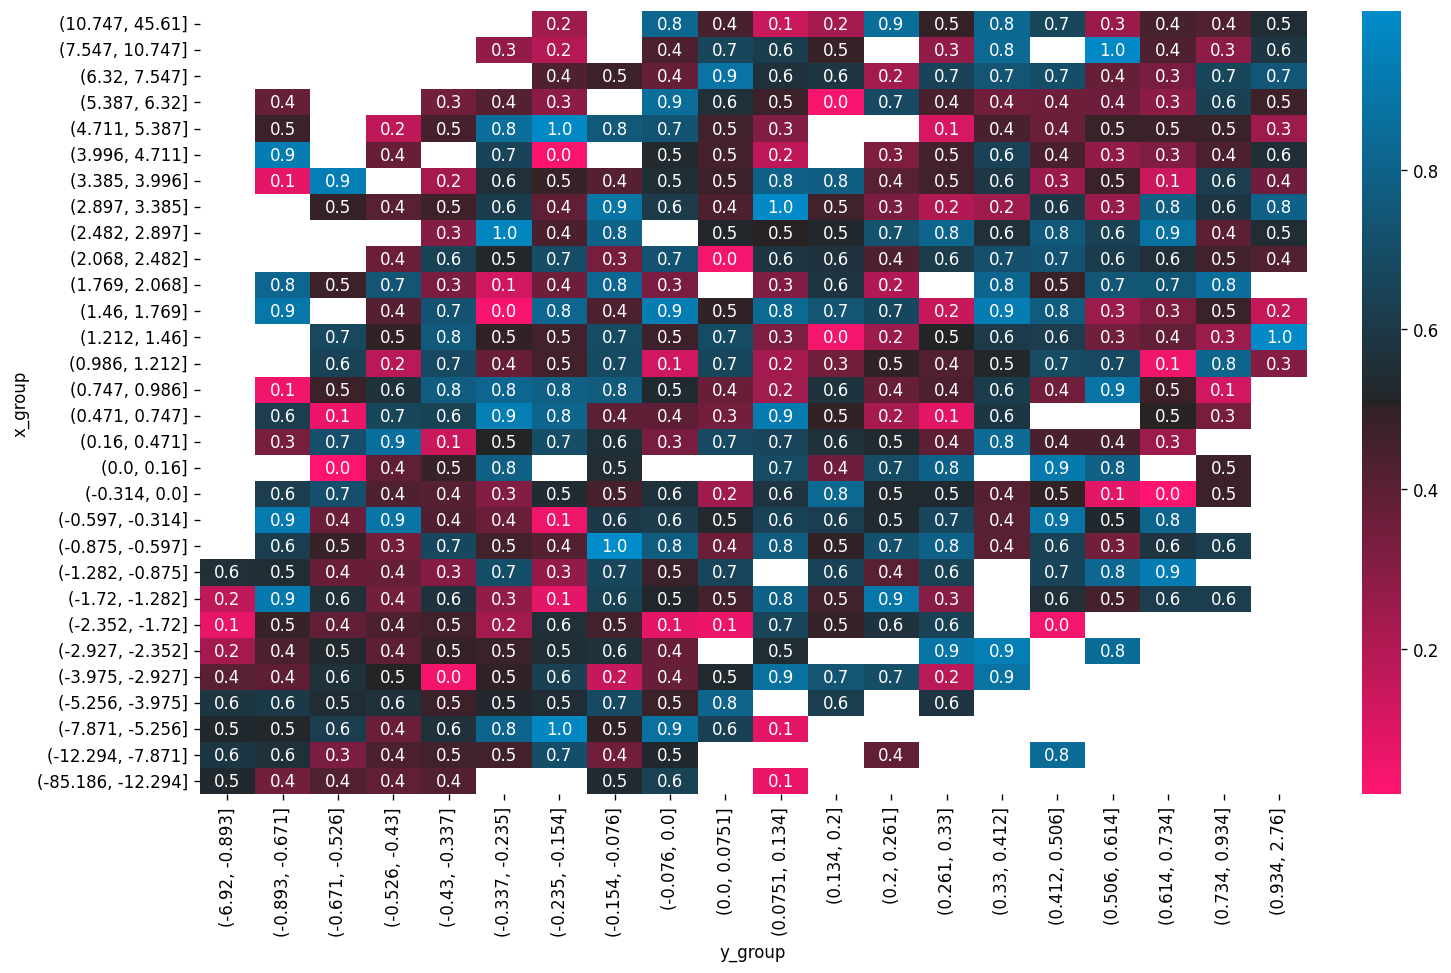

In [117]:
plt.rcParams['figure.figsize'] = [12, 8]
grpd = day_data.groupby(['x_group', 'y_group'])[['percent']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='x_group', columns='y_group', values='percent').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

In [118]:
day_data

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,percent,overnigh,9h_on_highlow,x_group,y_group
Date,,,,,,,,,,,,,,
2018-08-16,942.4,947.0,947.3,935.5,942.0,944.0,17.896244,30.0,0.714286,0.550847,-4.859497,-1.000000,"(-5.256, -3.975]","(-6.92, -0.893]"
2018-08-17,952.2,947.0,954.6,945.0,953.0,947.4,77.237192,-14.0,1.000000,0.833333,6.335797,0.762712,"(6.32, 7.547]","(0.734, 0.934]"
2018-08-20,946.1,945.0,951.5,942.6,945.8,946.4,35.866439,-30.0,0.222222,0.359551,-1.267159,-0.166667,"(-1.282, -0.875]","(-0.235, -0.154]"
2018-08-21,944.7,958.5,958.5,944.0,944.5,950.8,36.245234,-12.0,0.714286,0.034483,-0.529101,-0.213483,"(-0.597, -0.314]","(-0.235, -0.154]"
2018-08-22,959.5,957.0,960.6,953.6,959.3,957.8,84.573704,34.0,0.090909,0.814286,0.834637,0.586207,"(0.747, 0.986]","(0.506, 0.614]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.2,1292.9,83.969729,20.0,0.500000,0.492754,4.824903,1.560976,"(4.711, 5.387]","(0.934, 2.76]"
2024-07-30,1286.1,1292.4,1292.4,1284.2,1285.6,1284.9,20.087542,22.0,0.500000,0.170732,-1.708340,-1.057971,"(-1.72, -1.282]","(-6.92, -0.893]"
2024-07-31,1292.0,1304.3,1304.3,1291.1,1292.3,1300.5,66.231758,36.0,0.411765,0.090909,-0.077375,0.902439,"(-0.314, 0.0]","(0.734, 0.934]"
